### Error calcs for VWIND constraint

In [1]:
import importlib
import pandas as pd
import xarray as xr
import numpy as np
import sys
import warnings
from scipy import signal 
import glob as glob

from ecpaper_utils import bootstrap_utils as boot
from ecpaper_utils import filter_utils as filt
from ecpaper_utils import averaging_utils as avg

importlib.reload(boot)
importlib.reload(avg)

warnings.filterwarnings('ignore')

In [2]:
cmip5models=pd.read_csv("../../DATASORT/cmip5csvinfo.csv")
cmip6models=pd.read_csv("../../DATASORT/cmip6csvinfo.csv")

In [15]:
vwind_path="/project/cas/islas/python_savs/ecpaper2020/DATASORT/VWIND/"

In [17]:
le_models = ['CanESM2','CESM1-CAM5','CSIRO-Mk3-6-0','GFDL-CM3','MPI-ESM']
le_dat = []

for le in le_models:
    print(le)
    ## vwind
    ds = xr.open_dataset(vwind_path+"v300_"+le+".nc")
    ## precip
    dsp = xr.open_dataset(vwind_path+"pr_"+le+".nc").rename({"Member": "member"})
    ## u100
    dsu = xr.open_dataset(vwind_path+"u100_"+le+".nc")
    ds = xr.merge([ds, dsp, dsu]).assign_coords({"Model": le})
    le_dat.append(ds)

CanESM2
CESM1-CAM5
CSIRO-Mk3-6-0
GFDL-CM3
MPI-ESM


In [19]:
le_dat = xr.concat(le_dat, dim = "Model")

### calculate ensemble values for each LE

In [20]:
le_vdiff = []
le_vamp = []
le_pdiff_west = []
le_pdiff_south = []
le_pdiff_mex = []
le_udiff = []

for le in le_models: 
    print(le)
    ds = le_dat.sel(Model = le).dropna(dim = "member", how = "all").mean(dim = "member")
    vpast_eddy = ds["vpast_djf"] - ds["vpast_djf"].mean("lon")
    vfut_eddy = ds["vfut_djf"] - ds["vfut_djf"].mean("lon")
    vpastsw = avg.cosweightlonlat(vpast_eddy, 250, 265, 25, 37)
    vfutsw = avg.cosweightlonlat(vfut_eddy, 250, 265, 25, 37)   
    le_vdiff.append((vfutsw - vpastsw).values)
    
    # stationary wave ampltiude index
    vpast_k4to32 = filt.filterk(ds["vpast_djf"], 4, 32)
    vpast_amp = np.sqrt(avg.cosweightlonlat(vpast_k4to32**2, 200., 300., 20., 40.))
    le_vamp.append(vpast_amp.values)
        
    ## change in precipitation
    le_pdiff_west.append((ds["prf_west"] - ds["prp_west"]).values)
    le_pdiff_south.append((ds["prf_south"] - ds["prp_south"]).values)
    le_pdiff_mex.append((ds["prf_mex"] - ds["prp_mex"]).values)
    
    ## change in u100
    up = avg.cosweightlat(ds["upast_djf"],20,40)
    uf = avg.cosweightlat(ds["ufut_djf"],20, 40)
    le_udiff.append((uf - up).values)
    

CanESM2
CESM1-CAM5
CSIRO-Mk3-6-0
GFDL-CM3
MPI-ESM


### calculate errors for CMIP5 models

In [21]:
models = cmip5models['Model']
nmodels = models.shape[0]
nboots = 1000

sig_vdiff = np.zeros(nmodels) 
sig_udiff = np.zeros(nmodels)
sig_psi = np.zeros(nmodels) 
sig_pdiff_west = np.zeros(nmodels) 
sig_pdiff_south = np.zeros(nmodels)
sig_pdiff_mex = np.zeros(nmodels)

r_psi_vdiff = np.zeros(nmodels)
r_udiff_vdiff = np.zeros(nmodels)
r_psi_prwest = np.zeros(nmodels)
r_psi_prsouth = np.zeros(nmodels)
r_psi_prmex = np.zeros(nmodels)

for i, model in enumerate(models):
    print(model)
    nmemp=cmip5models.loc[i, "Nmempast"]
    nmemf=cmip5models.loc[i, "Nmemfuture"]
    
    boots_vdiff = []
    boots_udiff = []
    boots_vamp = []
    boots_pdiff_west = []
    boots_pdiff_south = []
    boots_pdiff_mex = []
    
    for j, le in enumerate(le_models):
        
        ds = le_dat.sel(Model = le).dropna(dim = "member", how = "all")
        
        ## bootstrapped V300
        vpast = boot.bootgen_multimem(ds["vpast_djf"], nmemp, seed=3, nboots = nboots)
        vfut = boot.bootgen_multimem(ds["vfut_djf"], nmemf, seed=3, nboots = nboots)
        
        vpast_eddy = vpast - vpast.mean("lon")
        vfut_eddy = vfut - vfut.mean("lon")
        vpastsw = avg.cosweightlonlat(vpast_eddy, 250, 265, 25, 37)
        vfutsw = avg.cosweightlonlat(vfut_eddy, 250, 265, 25, 37)
        
        ## change in v300 SW
        boots_vdiff.append((vfutsw - vpastsw).values - le_vdiff[j])
        
        # stationary wave ampltiude index
        vpast_k4to32 = filt.filterk(vpast, 4, 32)
        vpast_amp = np.sqrt(avg.cosweightlonlat(vpast_k4to32**2, 200., 300., 20., 40.))
        
        boots_vamp.append(vpast_amp.values - le_vamp[j])
        
        ## u100 difference
        upast = boot.bootgen_multimem(ds["upast_djf"], nmemp, seed = 3, nboots = nboots)
        upast = avg.cosweightlat(upast,20,40)
        ufut = boot.bootgen_multimem(ds["ufut_djf"], nmemf, seed = 3, nboots = nboots)
        ufut = avg.cosweightlat(ufut,20, 40)
        boots_udiff.append(ufut.values - upast.values - le_udiff[j])
        
        ## calculate precip changes for three regions
        prp = boot.bootgen_multimem(ds["prp_west"], nmemp, seed = 3, nboots = nboots)
        prf = boot.bootgen_multimem(ds["prf_west"], nmemf, seed = 3, nboots = nboots)
        boots_pdiff_west.append(prf.values - prp.values - le_pdiff_west[j])
        
        prp = boot.bootgen_multimem(ds["prp_south"], nmemp, seed = 3, nboots = nboots)
        prf = boot.bootgen_multimem(ds["prf_south"], nmemf, seed = 3, nboots = nboots)
        boots_pdiff_south.append(prf.values - prp.values - le_pdiff_south[j])
        
        prp = boot.bootgen_multimem(ds["prp_mex"], nmemp, seed = 3, nboots = nboots)
        prf = boot.bootgen_multimem(ds["prf_mex"], nmemf, seed = 3, nboots = nboots)
        boots_pdiff_mex.append(prf.values - prp.values - le_pdiff_mex[j])
    
    boots_vdiff = np.concatenate(boots_vdiff)
    boots_udiff = np.concatenate(boots_udiff)
    boots_vamp = np.concatenate(boots_vamp)
    boots_pdiff_west = np.concatenate(boots_pdiff_west)
    boots_pdiff_south = np.concatenate(boots_pdiff_south)
    boots_pdiff_mex = np.concatenate(boots_pdiff_mex)
    
    sig_vdiff[i] = np.std(boots_vdiff)
    sig_udiff[i] = np.std(boots_udiff)
    sig_psi[i] = np.std(boots_vamp)
    sig_pdiff_west[i] = np.std(boots_pdiff_west)
    sig_pdiff_south[i] = np.std(boots_pdiff_south)
    sig_pdiff_mex[i] = np.std(boots_pdiff_mex)
    
    r_psi_vdiff[i] = np.corrcoef(boots_vamp, boots_vdiff)[0,1]
    r_udiff_vdiff[i] = np.corrcoef(boots_udiff, boots_vdiff)[0,1]
    r_psi_prwest[i] = np.corrcoef(boots_vamp, boots_pdiff_west)[0,1]
    r_psi_prsouth[i] = np.corrcoef(boots_vamp, boots_pdiff_south)[0,1]
    r_psi_prmex[i] = np.corrcoef(boots_vamp, boots_pdiff_mex)[0,1]

ACCESS1-0
ACCESS1-3
bcc-csm1-1
bcc-csm1-1-m
BNU-ESM
CanESM2
CCSM4
CESM1-BGC
CESM1-CAM5
CESM1-WACCM
CMCC-CM
CMCC-CMS
CNRM-CM5
CSIRO-Mk3-6-0
EC-EARTH
FGOALS-g2
FIO-ESM
GFDL-CM3
GFDL-ESM2G
GFDL-ESM2M
GISS-E2-H
GISS-E2-R
HadGEM2-AO
HadGEM2-CC
HadGEM2-ES
inmcm4
IPSL-CM5A-LR
IPSL-CM5A-MR
IPSL-CM5B-LR
MIROC5
MIROC-ESM
MIROC-ESM-CHEM
MPI-ESM-LR
MPI-ESM-MR
MRI-CGCM3
NorESM1-M
NorESM1-ME


In [22]:
error_dat5 = xr.Dataset({'sig_vdiff': xr.DataArray(sig_vdiff, coords=[models], dims=["Model"]), 
                       'sig_psi': xr.DataArray(sig_psi, coords=[models], dims=["Model"]), 
                         'sig_udiff': xr.DataArray(sig_udiff, coords=[models], dims=["Model"]),
                        'sig_pdiff_west': xr.DataArray(sig_pdiff_west, coords=[models], dims=["Model"]), 
                        'sig_pdiff_south': xr.DataArray(sig_pdiff_south, coords=[models], dims=["Model"]), 
                        'sig_pdiff_mex': xr.DataArray(sig_pdiff_mex, coords=[models], dims=["Model"]), 
                        'r_psi_vdiff': xr.DataArray(r_psi_vdiff, coords=[models], dims=["Model"]), 
                         'r_udiff_vdiff': xr.DataArray(r_udiff_vdiff, coords=[models], dims=["Model"]),
                        'r_psi_prwest': xr.DataArray(r_psi_prwest, coords=[models], dims=["Model"]), 
                        'r_psi_prsouth': xr.DataArray(r_psi_prsouth, coords=[models], dims=["Model"]), 
                        'r_psi_prmex': xr.DataArray(r_psi_prmex, coords=[models], dims=["Model"])})

error_dat5.to_netcdf("./DATA/errors_cmip5.nc")

In [23]:
models = cmip6models['Model']
nmodels = models.shape[0]
nboots = 1000

sig_vdiff = np.zeros(nmodels) 
sig_udiff = np.zeros(nmodels)
sig_psi = np.zeros(nmodels) 
sig_pdiff_west = np.zeros(nmodels) 
sig_pdiff_south = np.zeros(nmodels)
sig_pdiff_mex = np.zeros(nmodels)

r_psi_vdiff = np.zeros(nmodels)
r_udiff_vdiff = np.zeros(nmodels)
r_psi_prwest = np.zeros(nmodels)
r_psi_prsouth = np.zeros(nmodels)
r_psi_prmex = np.zeros(nmodels)

for i, model in enumerate(models):
    print(model)
    nmemp=cmip6models.loc[i, "Nmempast"]
    nmemf=cmip6models.loc[i, "Nmemfuture"]
    
    boots_vdiff = []
    boots_udiff = []
    boots_vamp = []
    boots_pdiff_west = []
    boots_pdiff_south = []
    boots_pdiff_mex = []
    
    for j, le in enumerate(le_models):

        ds = le_dat.sel(Model = le).dropna(dim = "member", how = "all")
        
        ## bootstrapped V300
        vpast = boot.bootgen_multimem(ds["vpast_djf"], nmemp, seed=3, nboots = nboots)
        vfut = boot.bootgen_multimem(ds["vfut_djf"], nmemf, seed=3, nboots = nboots)
        
        vpast_eddy = vpast - vpast.mean("lon")
        vfut_eddy = vfut - vfut.mean("lon")
        vpastsw = avg.cosweightlonlat(vpast_eddy, 250, 265, 25, 37)
        vfutsw = avg.cosweightlonlat(vfut_eddy, 250, 265, 25, 37)
        
        ## change in v300 SW
        boots_vdiff.append((vfutsw - vpastsw).values - le_vdiff[j])
        
        # stationary wave ampltiude index
        vpast_k4to32 = filt.filterk(vpast, 4, 32)
        vpast_amp = np.sqrt(avg.cosweightlonlat(vpast_k4to32**2, 200., 300., 20., 40.))
        
        boots_vamp.append(vpast_amp.values - le_vamp[j])

        ## u100 difference
        upast = boot.bootgen_multimem(ds["upast_djf"], nmemp, seed = 3, nboots = nboots)
        upast = avg.cosweightlat(upast,20,40)
        ufut = boot.bootgen_multimem(ds["ufut_djf"], nmemf, seed = 3, nboots = nboots)
        ufut = avg.cosweightlat(ufut,20, 40)
        boots_udiff.append(ufut.values - upast.values - le_udiff[j])
        
        ## calculate precip changes for three regions
        prp = boot.bootgen_multimem(ds["prp_west"], nmemp, seed = 3, nboots = nboots)
        prf = boot.bootgen_multimem(ds["prf_west"], nmemf, seed = 3, nboots = nboots)
        boots_pdiff_west.append(prf.values - prp.values - le_pdiff_west[j])
        
        prp = boot.bootgen_multimem(ds["prp_south"], nmemp, seed = 3, nboots = nboots)
        prf = boot.bootgen_multimem(ds["prf_south"], nmemf, seed = 3, nboots = nboots)
        boots_pdiff_south.append(prf.values - prp.values - le_pdiff_south[j])
        
        prp = boot.bootgen_multimem(ds["prp_mex"], nmemp, seed = 3, nboots = nboots)
        prf = boot.bootgen_multimem(ds["prf_mex"], nmemf, seed = 3, nboots = nboots)
        boots_pdiff_mex.append(prf.values - prp.values - le_pdiff_mex[j])
    
    boots_vdiff = np.concatenate(boots_vdiff)
    boots_udiff = np.concatenate(boots_udiff)
    boots_vamp = np.concatenate(boots_vamp)
    boots_pdiff_west = np.concatenate(boots_pdiff_west)
    boots_pdiff_south = np.concatenate(boots_pdiff_south)
    boots_pdiff_mex = np.concatenate(boots_pdiff_mex)
    
    sig_vdiff[i] = np.std(boots_vdiff)
    sig_udiff[i] = np.std(boots_udiff)
    sig_psi[i] = np.std(boots_vamp)
    sig_pdiff_west[i] = np.std(boots_pdiff_west)
    sig_pdiff_south[i] = np.std(boots_pdiff_south)
    sig_pdiff_mex[i] = np.std(boots_pdiff_mex)
    
    r_psi_vdiff[i] = np.corrcoef(boots_vamp, boots_vdiff)[0,1]
    r_udiff_vdiff[i] = np.corrcoef(boots_udiff, boots_vdiff)[0,1]
    r_psi_prwest[i] = np.corrcoef(boots_vamp, boots_pdiff_west)[0,1]
    r_psi_prsouth[i] = np.corrcoef(boots_vamp, boots_pdiff_south)[0,1]
    r_psi_prmex[i] = np.corrcoef(boots_vamp, boots_pdiff_mex)[0,1]

ACCESS-CM2
ACCESS-ESM1-5
AWI-CM-1-1-MR
BCC-CSM2-MR
CAMS-CSM1-0
CanESM5
CanESM5-CanOE
CESM2
CESM2-WACCM
CIESM
CMCC-CM2-SR5
CNRM-CM6-1
CNRM-CM6-1-HR
CNRM-ESM2-1
EC-Earth3
EC-Earth3-Veg
FGOALS-f3-L
FGOALS-g3
FIO-ESM-2-0
GFDL-CM4
GFDL-ESM4
GISS-E2-1-G
HadGEM3-GC31-LL
HadGEM3-GC31-MM
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
KACE-1-0-G
MCM-UA-1-0
MIROC6
MIROC-ES2L
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NESM3
NorESM2-LM
NorESM2-MM
UKESM1-0-LL


In [24]:
error_dat6 = xr.Dataset({'sig_vdiff': xr.DataArray(sig_vdiff, coords=[models], dims=["Model"]), 
                       'sig_psi': xr.DataArray(sig_psi, coords=[models], dims=["Model"]), 
                         'sig_udiff': xr.DataArray(sig_udiff, coords=[models], dims=["Model"]),
                        'sig_pdiff_west': xr.DataArray(sig_pdiff_west, coords=[models], dims=["Model"]), 
                        'sig_pdiff_south': xr.DataArray(sig_pdiff_south, coords=[models], dims=["Model"]), 
                        'sig_pdiff_mex': xr.DataArray(sig_pdiff_mex, coords=[models], dims=["Model"]), 
                        'r_psi_vdiff': xr.DataArray(r_psi_vdiff, coords=[models], dims=["Model"]), 
                         'r_udiff_vdiff': xr.DataArray(r_udiff_vdiff, coords=[models], dims=["Model"]),
                        'r_psi_prwest': xr.DataArray(r_psi_prwest, coords=[models], dims=["Model"]), 
                        'r_psi_prsouth': xr.DataArray(r_psi_prsouth, coords=[models], dims=["Model"]), 
                        'r_psi_prmex': xr.DataArray(r_psi_prmex, coords=[models], dims=["Model"])})

error_dat6.to_netcdf("./DATA/errors_cmip6.nc")

In [14]:
error_dat6

<xarray.Dataset>
Dimensions:          (Model: 38)
Coordinates:
  * Model            (Model) object 'ACCESS-CM2' ... 'UKESM1-0-LL'
Data variables:
    sig_vdiff        (Model) float64 0.6675 0.4369 0.6039 ... 0.7591 0.3568
    sig_psi          (Model) float64 0.182 0.1483 0.1134 ... 0.2585 0.1271
    sig_udiff        (Model) float64 0.3929 0.2454 0.3695 ... 0.4271 0.1958
    sig_pdiff_west   (Model) float64 0.2391 0.1511 0.2259 ... 0.2639 0.1211
    sig_pdiff_south  (Model) float64 0.1164 0.07471 0.1053 ... 0.1314 0.06055
    sig_pdiff_mex    (Model) float64 0.07323 0.04979 0.06387 ... 0.0861 0.04167
    r_psi_vdiff      (Model) float64 0.162 0.2103 0.1079 ... 0.1941 0.2245
    r_udiff_vdiff    (Model) float64 -0.2537 -0.2136 -0.2767 ... -0.2159 -0.2216
    r_psi_prwest     (Model) float64 0.008897 -0.004041 ... 0.003849 -0.006856
    r_psi_prsouth    (Model) float64 -0.06568 -0.05875 ... -0.08358 -0.0625
    r_psi_prmex      (Model) float64 -0.1479 -0.1593 ... -0.1584 -0.1646

### Checking results...

In [15]:
import matplotlib.pyplot as plt

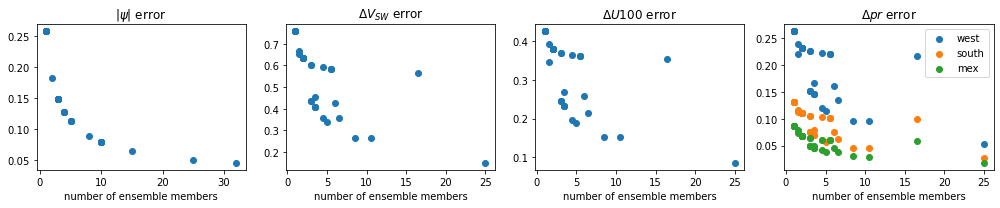

In [16]:
fig = plt.figure(figsize = (14, 3))

ax = fig.add_subplot(141)
ax.scatter(cmip6models["Nmempast"], error_dat6["sig_psi"])
ax.set(xlabel = "number of ensemble members", title = "$|\psi|$ error")

ax = fig.add_subplot(142)
ax.scatter(cmip6models["Nmempast"]/2+cmip6models["Nmemfuture"]/2, error_dat6["sig_vdiff"]) ## plot average of Nmempast + Nmemfuture
ax.set(xlabel = "number of ensemble members", title = "$\Delta V_{SW}$ error") 


ax = fig.add_subplot(143)
ax.scatter(cmip6models["Nmempast"]/2+cmip6models["Nmemfuture"]/2, error_dat6["sig_udiff"]) ## plot average of Nmempast + Nmemfuture
ax.set(xlabel = "number of ensemble members", title = "$\Delta U100$ error") 

ax = fig.add_subplot(144)
ax.scatter(cmip6models["Nmempast"]/2+cmip6models["Nmemfuture"]/2, error_dat6["sig_pdiff_west"]) ## plot average of Nmempast + Nmemfuture
ax.scatter(cmip6models["Nmempast"]/2+cmip6models["Nmemfuture"]/2, error_dat6["sig_pdiff_south"]) 
ax.scatter(cmip6models["Nmempast"]/2+cmip6models["Nmemfuture"]/2, error_dat6["sig_pdiff_mex"]) 
ax.set(xlabel = "number of ensemble members", title = "$\Delta pr$ error")
ax.legend(labels = ["west", "south", "mex"])

plt.tight_layout()